/home/pradeep/Downloads/courses/DIP/project/submission_codes/bin_compress.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('torch_vae/saved_params/torch_binar

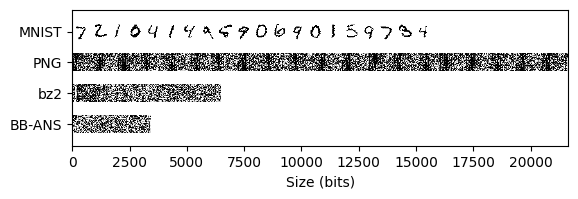

In [1]:
import numpy as np
import torch
import rans
# from benchmark_compressors import mnist_binarized, bz2_compress, pimg_compress

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.image import BboxImage

import os
import torch
import numpy as np
import util
import rans
from torch_vae.tvae_beta_binomial import BetaBinomialVAE
from torch_vae import tvae_utils
from torchvision import datasets, transforms
import time
from PIL import Image
import io
import gzip
import bz2
import lzma
import numpy as np
from bin_compress import vae_append

# from data.load_imagenet import load_imagenet_valid
from torchvision import datasets, transforms
import PIL.Image as pimg


def mnist_binarized(rng):
    raw_probs = mnist_raw() / 255
    return rng.random_sample(np.shape(raw_probs)) < raw_probs


def bz2_compress(images):
    original_size = np.size(images)
    images = np.packbits(images) if images.dtype is np.dtype(bool) else images
    assert images.dtype is np.dtype('uint8')
    return bz2.compress(images.tobytes())


def pimg_compress(format='PNG', **params):
    def compress_fun(images):
        compressed_data = bytearray()
        for n, image in enumerate(images):
            image = pimg.fromarray(image)
            img_bytes = io.BytesIO()
            image.save(img_bytes, format=format, **params)
            compressed_data.extend(img_bytes.getvalue())
        return compressed_data
    return compress_fun

def mnist_raw():
    mnist = datasets.MNIST(
        'data/mnist', train=False, download=True,
        transform=transforms.Compose([transforms.ToTensor()]))
    return mnist.test_data.numpy()

def mnist_binarized(rng):
    raw_probs = mnist_raw() / 255
    return rng.random_sample(np.shape(raw_probs)) < raw_probs

def bench_compressor(compress_fun, compressor_name, images, images_name):
    byts = compress_fun(images)
    n_bits = len(byts) * 8
    bits_per_pixel = n_bits / np.size(images)
    print("Dataset: {}. Compressor: {}. Rate: {:.2f} bits per channel.".
          format(images_name, compressor_name, bits_per_pixel))
    
def bytes_to_img(byts):
    arr = np.unpackbits(np.frombuffer(byts, dtype='uint8'))
    arr = np.concatenate((arr, np.ones(28 - arr.size % 28)))
    return np.reshape(arr, (h, -1), order='F')

rng = np.random.RandomState(0)

fig, ax = plt.subplots()

N = 20
spacing = 20
h = 28

raw_data = mnist_binarized(rng)[:N]


bz2_compressed = bytes_to_img(bz2_compress(raw_data))
png_compressed = bytes_to_img(pimg_compress(optimize=True)(raw_data))

other_bits = rng.randint(1 << 32, size=12, dtype=np.uint32)
state = rans.unflatten(other_bits)

images = torch.from_numpy(raw_data.astype('float32'))
images = [image.view(-1) for image in images]

for image in images:
    state = vae_append(state, image)
bb_ans_compressed = bytes_to_img(rans.flatten(state).tobytes())

raw_data = np.concatenate(~raw_data, axis=1)

labels = ["BB-ANS",          "bz2",          "PNG",          "MNIST"]
data   = [bb_ans_compressed, bz2_compressed, png_compressed, raw_data          ]

yticks = []
for i, d in enumerate(data):
    bbox = Bbox.from_bounds(0, 28 * (spacing + i * (h + spacing)),
                            28 * d.shape[1], 28 * h)
    bbox = TransformedBbox(bbox, ax.transData)
    bbox_image = BboxImage(bbox, cmap='gray', origin=None)
    bbox_image.set_data(d)
    ax.add_artist(bbox_image)
    yticks.append(28 * (spacing + i * (h + spacing) + h // 2))

ax.set_xlim(0, max(28 * d.shape[1] for d in data))
ax.set_yticks(yticks)
ax.set_yticklabels(labels)
ax.set_ylim(0, 28 * (spacing + (i + 1) * (h + spacing)))
ax.set_xlabel('Size (bits)')
ax.set_aspect('equal')
plt.savefig('compression_plot.png', dpi=800, bbox_inches='tight')
